# Sharpe Style Analysis

Sharpe Style Analysis is an elegant and simple decomposition exercise similar to what we did in the previous lab session, with the added constraint that the coefficients are all positive and add to 1.

Therefore, the coefficients of performing style analysis on the observed return of a manager can be interpreted as weights in a portfolio of building blocks which together, _mimic_ that return series. The exercise can reveal drifts in a manager's style as well as provide insight into what the manager is likely doing to obtain the returns.



y (N x 1): portfolio manager's return that we are interested to analyze its style effects

X (N x K): industeries return 

W (K x 1): weights give us insights regarding portfolio's stylized effects


$$ \min_{w}   \| y - X w \|_{2} 
\\ \text{subject to} \quad w > 0, 
\\ \sum w= 1$$


# Performing Sharpe Style Analysis

The key to obtaining the weights is our old friend, the quadriatic optimizer. We are asking the optimizer to find the weights that minimizes the square of the difference between the observed series and the returns of a benchmark portfolio that holds the explanatory building blocks in those same weights. This is equivalent to minimizing the _tracking error_ between the two return series.

The code to implement this is a very slight modification of the `minimize_vol` we have previously implemented:

```python                         
def style_analysis(dependent_variable, explanatory_variables):
    """
    Returns the optimal weights that minimizes the Tracking error between
    a portfolio of the explanatory variables and the dependent variable
    """
    n = explanatory_variables.shape[1]
    init_guess = np.repeat(1/n, n)
    bounds = ((0.0, 1.0),) * n # an N-tuple of 2-tuples!
    # construct the constraints
    weights_sum_to_1 = {'type': 'eq',
                        'fun': lambda weights: np.sum(weights) - 1
    }
    solution = minimize(portfolio_tracking_error, init_guess,
                       args=(dependent_variable, explanatory_variables,), method='SLSQP',
                       options={'disp': False},
                       constraints=(weights_sum_to_1,),
                       bounds=bounds)
    weights = pd.Series(solution.x, index=explanatory_variables.columns)
    return weights
```

The Objective function is a very simple one-liner

```python
def portfolio_tracking_error(weights, ref_r, bb_r):
    """
    returns the tracking error between the reference returns
    and a portfolio of building block returns held with given weights
    """
    return tracking_error(ref_r, (weights*bb_r).sum(axis=1))
```

In [1]:
import numpy as np
import pandas as pd
import edhec_risk_kit_202 as erk
%load_ext autoreload
%autoreload 2


In [6]:
ind = erk.get_ind_returns()["2000":]

print(f"shape of ind is {ind.shape}")
print("list of industeries \n", list(ind.columns))
pd.concat([ind.head(3), ind.tail(3)], axis = 0)

shape of ind is (228, 30)
list of industeries 
 ['Food', 'Beer', 'Smoke', 'Games', 'Books', 'Hshld', 'Clths', 'Hlth', 'Chems', 'Txtls', 'Cnstr', 'Steel', 'FabPr', 'ElcEq', 'Autos', 'Carry', 'Mines', 'Coal', 'Oil', 'Util', 'Telcm', 'Servs', 'BusEq', 'Paper', 'Trans', 'Whlsl', 'Rtail', 'Meals', 'Fin', 'Other']


,Food,Beer,Smoke,Games,Books,Hshld,Clths,Hlth,Chems,Txtls,...,Telcm,Servs,BusEq,Paper,Trans,Whlsl,Rtail,Meals,Fin,Other
2000-01,-0.0829,-0.0228,-0.0862,0.0229,-0.0092,-0.0651,-0.1138,0.0756,-0.0933,-0.0764,...,-0.0404,-0.0973,-0.0064,-0.0878,-0.0959,0.0899,-0.1453,-0.0739,-0.0442,-0.0412
2000-02,-0.0689,-0.1164,-0.0401,-0.0177,-0.0071,-0.1157,-0.1278,-0.0288,-0.0729,-0.0584,...,-0.0359,0.0759,0.2509,-0.1142,-0.0535,0.0113,-0.0393,-0.1203,-0.0849,-0.0061
2000-03,0.0969,0.0013,0.0511,0.1052,0.1293,-0.1426,0.2506,0.0028,0.1217,0.0535,...,0.0757,0.0269,0.0456,0.0836,0.1287,0.0659,0.1436,0.1598,0.1669,-0.0016
2018-10,0.0102,-0.0157,0.0790,-0.1596,-0.0666,-0.0051,-0.1014,-0.0884,-0.1250,-0.2579,...,-0.0050,-0.0920,-0.0806,-0.0982,-0.0975,-0.0788,-0.1021,-0.0171,-0.0545,-0.0599
2018-11,0.0272,0.0579,-0.0843,-0.0065,0.0325,0.0644,-0.0099,0.0632,0.0496,0.0292,...,0.0254,0.0129,-0.0505,0.0822,0.0617,0.0318,0.0159,0.0616,0.0289,0.0348
2018-12,-0.0973,-0.0969,-0.1580,-0.0824,-0.1535,-0.0557,-0.0728,-0.0840,-0.0776,-0.1009,...,-0.0884,-0.0765,-0.0923,-0.0863,-0.1519,-0.1121,-0.0919,-0.0628,-0.1144,-0.0693


In [21]:
import plotly.graph_objects as go

fig_data = [go.Scatter(name = col,x=ind.index.strftime('%Y-%m'), y=((ind[col]+1).cumprod() -1)) for col in ind.columns]
fig = go.Figure(data=fig_data, layout=go.Layout(height=400, width=900,  title='Cumulative Performance of Industeries'))
fig.show()

Let's construct a manager that invests in 30% Beer, 50% in Smoke and 20% in other things that have an average return of 0% and an annualized vol of 15%

In [26]:
mgr_r = 0.3*ind["Beer"] + .5*ind["Smoke"] + 0.2*np.random.normal(scale=0.15/(12**.5), size=ind.shape[0])

fig_data = [go.Scatter(name = "portfolio manager",x=mgr_r.index.strftime('%Y-%m'), y=((mgr_r+1).cumprod() -1))]
fig = go.Figure(data=fig_data, layout=go.Layout(height=400, width=900,  title='Cumulative Performance of the Random portfolio Manager'))
fig.show()

Now, assume we knew absolutely nothing about this manager and all we observed was the returns. How could we tell what she was invested in?

We can apply sharepe style analysis to see how her portfolio is composed from different industeries by running quadrtic programming.


#### Interesting to see different way to minimize the TE

2 ways to do it

1. 

$$ \min_{w}   \| y - X w \|_{2} $$


2.


$$ \min_{w}   \| y - X w \|_{2}^2 $$



Simple Conclusion: L2 norm is more common when miniming Tracking Error. It's usually used find the weights of a portfolio that mimics a target. 
In some cases, minimizing the L2 norm may be more appropriate if we want to prioritize minimizing the actual distance between the desired and actual trajectories. In other cases, minimizing the L2 norm squared may be more appropriate if we want to put more emphasis on penalization of larger errors.



In [99]:
from scipy.optimize import minimize

def TE_minimize(mgr_r, ind, obj_func):
    n = ind.shape[1]
    init_w = np.repeat(1/n, n)
    y_ret = mgr_r
    X_ret = ind
    # constraints
    bounds = ((0.0, 1.0),) * n
    weights_sum_to_1 = {'type': 'eq',
                        'fun': lambda weights: np.sum(weights) - 1
    }
    solution = minimize(obj_func, # lambda w, y_ret, X_ret: np.linalg.norm(y_ret-X_ret@w)
                        init_w,
                        args=(y_ret, X_ret), method='SLSQP',
                        options={'disp': False},
                        constraints=(weights_sum_to_1,),
                        bounds=bounds)

    weights = pd.Series(solution.x, index=ind.columns)
    return weights

weights1 = TE_minimize(mgr_r, ind, lambda w, y_ret, X_ret: np.linalg.norm(y_ret-X_ret@w))
weights2 = TE_minimize(mgr_r, ind, lambda w, y_ret, X_ret: np.linalg.norm(y_ret-X_ret@w)**2)


from plotly.subplots import make_subplots
fig = make_subplots(rows=2, cols=2)

fig.add_trace(go.Bar(x = weights1.index, y = weights1), row=1, col=1)
fig.add_trace(go.Bar(x = weights1.index, y = weights1), row=1, col=2)
fig.add_trace(go.Bar(x = weights1.index, y = weights1-weights2), row=2, col=1)
fig.update_xaxes(title_text="Minimizing TE Weights using Method1", row=1, col=1)
fig.update_xaxes(title_text="Minimizing TE Weights using Method2", row=1, col=2)
fig.update_xaxes(title_text="Weights1 - Weights2", row=2, col=1)

fig.update_layout(height=700, width=1300)
fig.show()


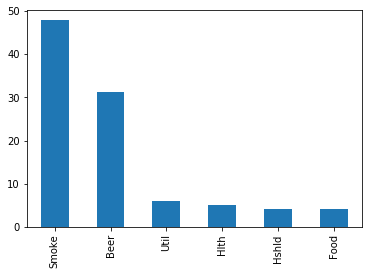

In [101]:
weights = erk.style_analysis(mgr_r, ind)*100

weights.sort_values(ascending=False).head(6).plot.bar()

Contrast this to the results of a regression. Because the model is in fact very true (i.e. we really did construct the manager's returns out of the building blocks), the results are remarkably accurate. However, the negative coefficients are hard to intepret and in real-life data, those will be much larger. However when it works well, such as in this artificial example here, the results can be very accurate.

$$ y = XW + \alpha $$


In [108]:
coeffs = erk.regress(mgr_r, ind).params*100

fig = make_subplots(rows=1, cols=1)
fig.add_trace(go.Bar(x = coeffs.index, y = coeffs), row=1, col=1)
fig.update_xaxes(title_text="Minimizing TE Weights using Method1", row=1, col=1)
fig.update_layout(height=300, width=800)
fig.show()

coeffs.sort_values().head()

FabPr   -5.946884
Other   -5.670953
Food    -5.339133
Meals   -4.408055
Paper   -3.411116
dtype: float64

Negative 4.5% in Household?

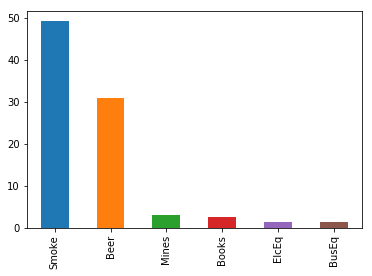

In [7]:
coeffs.sort_values(ascending=False).head(6).plot.bar()

## Style Drift: Time Varying Exposures using Style Anaylsis

One of the most common ways in which Sharpe Style Analysis can be used is to measure style drift. If you run the style analysis function over a rolling window of 1 to 5 years, you can extract changes in the style exposures of a manager.

We'll look at Rolling Windows in the next lab session.

As an exercise to the student, download a set of returns from Yahoo Finance, and try and measure the style drift in your favorite fund manager. Use reliable Value and Growth ETFs such as "SPYG" and "SPYV" along with a SmallCap ETF such as "SLY" and LargeCap ETF such as "OEF".

Alternately, the Fama-French research factors and use the Top and Bottom portfolios by Value (HML) and Size (SMB) to categorize mutual funds into categories. This is very similar to the "Style Box" methodology employed by Morningstar and displayed on their website. Compare your results with their results to see if they agree!

# Warning: Potential Misuse of Style Analysis

Style Analysis works best when the explanatory indices are in fact a good specification of what is happening. For instance, it usually gives you very useful and revealing insight if you use a stock market index (such as SPY) and other broad indices, ETFs or mutual funds (such as a Value Fund, a Growth Fund, an International Fund, a Bond Fund etc).

Part of the skill in extracting meaningful results is to pick the right set of explanatory variables.

However, a part of the challenge with Style Analysis is that it will _always_ return a portfolio. Although it is possible to develop a figure of merit of fit quality similar to an $R^2$, it will still always give you an answer, however unreasonable it might be, and it's not always obvious how much one can rely on the result.

For instance, we can try and extract the major industries that Buffer invested in since 2000 as follows:

In [111]:
brka_m = pd.read_csv("brka_m.csv", index_col=0, parse_dates=True).to_period('M')

In [112]:
mgr_r_b = brka_m["2000":]["BRKA"]
weights_b = erk.style_analysis(mgr_r_b, ind)
weights_b.sort_values(ascending=False).head(6).round(4)*100

Food     41.35
Fin      17.61
Meals    12.11
Other    11.03
Util      7.19
Clths     5.99
dtype: float64

If we want to look at the last decade (2009-2018):

In [113]:
brk2009 = brka_m["2009":]["BRKA"]
ind2009 = ind["2009":]
erk.style_analysis(brk2009, ind2009).sort_values(ascending=False).head(6).round(4)*100

Other    43.64
Food     28.33
Hlth     22.72
Rtail     5.25
Meals     0.07
Util      0.00
dtype: float64

Should you believe the analysis? Probably not. However, when the specification is in fact accurate (as we saw in the articially generated series) the results can be very revealing